# Script to Process and Analyze QuDit ramsey Data

## Read and process Data without error handling

In [221]:
import re
from datetime import datetime
import os
import numpy as np
import json
import matplotlib.pyplot as plt

# Define the directory path where the files are stored
directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

# Pattern: Ramsey_qudit_WaitTime1us_d=7_Cal_True_U1only_False_5_20250404_1615.txt
def parse_qudit_filename(filename):
    pattern = r'Ramsey_qudit_WaitTime\d+us_d=(\d+)_Cal_True_U1only_False_\d+_(\d{8})_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        d_value = int(match.group(1))
        date_str = match.group(2) + match.group(3)
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')
        return d_value, date_time
    return None, None

# Extract raw data filenames from the file
def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')]
    print(file_path)
    print(raw_data_filenames)
    return raw_data_filenames

# def search_files_by_d(directory, start_datetime=None):
#     d_value_dict = {}
#     for filename in os.listdir(directory):
#         if filename.startswith('Ramsey_qudit') and 'U1only_False' in filename:
#             d_value, date_time = parse_qudit_filename(filename)
#             # print(date_time)
#             if d_value is not None and (start_datetime is None or date_time >= start_datetime):
#                 file_path = os.path.join(directory, filename)
#                 raw_data_filenames = extract_raw_data_filenames(file_path)

#                 # 🔍 Filter: only accept text files with exactly 2 raw data file paths
#                 if len(raw_data_filenames) != 2:
#                     continue

#                 Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\'
#                 raw_data_filepaths = [
#                     raw_filename if os.path.isabs(raw_filename) else os.path.join(Z_drive_raw_data, raw_filename)
#                     for raw_filename in raw_data_filenames
#                 ]

#                 if d_value not in d_value_dict:
#                     d_value_dict[d_value] = []

#                 # Append list of raw file paths (grouped by .txt file)
#                 d_value_dict[d_value].append(raw_data_filepaths)
#     return d_value_dict

def search_files_by_d(directory, start_datetime=None, stop_datetime=None):
    d_value_dict = {}
    for filename in os.listdir(directory):
        if not filename.startswith('Ramsey_qudit') or 'U1only_False' not in filename:
            continue
        d_value, date_time = parse_qudit_filename(filename)
        if d_value is None:
            continue
        # Filter by date window if provided
        if start_datetime and date_time < start_datetime:
            continue
        if stop_datetime  and date_time > stop_datetime:
            continue
        summary_path = os.path.join(directory, filename)
        raw_list = extract_raw_data_filenames(summary_path)
        if len(raw_list) != 2:
            continue
        base = 'Z:/Lab Data/Qudit_Ramsey_raw_data/'
        raw_paths = [f if os.path.isabs(f) else os.path.join(base, f) for f in raw_list]
        d_value_dict.setdefault(d_value, []).append(raw_paths)
    return d_value_dict

# Calculate the shelving threshold
def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)[100:-100]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.0250167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    if threshold < 2:
        threshold = 10
    return threshold, data_sorted

def getShelvingThreshold(counts):
    data_sorted = np.sort(counts, axis=None)
    print("Total sorted data points:", len(data_sorted))
    # Remove extreme ends (if possible)
    if len(data_sorted) > 4000:
        data_sorted = data_sorted[2000:-2000]
    if len(data_sorted) > 2000:
        step = round(data_sorted.size / (len(counts) * 0.0250167))
        if step < 1:
            step = 1
        data_sorted = data_sorted[0:-1:step]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    
    # New logic: if the calculated threshold is less than 2, recalculate using histogram data.
    # if threshold < 2:
        # Calculate histogram in the x-range 4 to 30
    hist_counts, bin_edges = np.histogram(counts, bins=range(4, 31))
    # Find the bin (lowest bar) with the minimum count in that range
    min_bin_index = np.argmin(hist_counts)
    # Use the lower edge of that bin as the threshold
    threshold = bin_edges[min_bin_index] + 0.5
    print(f"Threshold recalculated using histogram: {threshold}")
    
    return threshold, data_sorted

def process_raw_data_files(grouped_raw_data_filepaths):
    ket_data_group = []
    for file_group in grouped_raw_data_filepaths:  # Each file_group is from one .txt file
        group_kets = []
        arrays = []
        for file_path in file_group:
            with open(file_path, 'r') as file:
                for line in file:
                    data = json.loads(line)
                    arrays.append(data[0]["0"])
        hist_data = np.array(arrays)
        flat_hist_data = hist_data.flatten()
        threshold, _ = get_shelving_threshold(flat_hist_data)
        print()
        print("Threshold:", threshold)

        arrays_3d = []
        for file_path in file_group:
            arrays = []
            with open(file_path, 'r') as file:
                for line in file:
                    data = json.loads(line)
                    arrays.append(data[0]["0"][:])
            arrays_3d.append(arrays)

        bool_array = np.array(arrays_3d) > threshold
        result_matrix = np.full(bool_array.shape, False, dtype=bool)

        not_all_darks = []
        first_h = []

        for matrix_index in range(bool_array.shape[0]):
            not_all_dark_counts = 0
            first_h_num = 0
            for row_index in range(bool_array.shape[1]):
                true_indices = np.where(bool_array[matrix_index, row_index, :])
                if true_indices[0].size > 0:
                    first_true_index = true_indices[0]
                    not_all_dark_counts += 1
                    if first_true_index[0] != 0:
                        first_h_num += 1
                        # if first_true_index[0] != 1:
                        result_matrix[matrix_index, row_index, first_true_index[0]] = True
            first_h.append(first_h_num)
            not_all_darks.append(not_all_dark_counts)

        print(not_all_darks)
        filtered_data_array = []
        for i in range(bool_array.shape[0]):
            data = result_matrix[i]
            rows_with_any_true = data.any(axis=1)
            filtered_data = data[rows_with_any_true]
            filtered_data_array.append(filtered_data)
            print(i, '|| all darks =', data.shape[0] - not_all_darks[i],
                  '|| failing first herald =', not_all_darks[i] - filtered_data.shape[0],
                  '|| deshelving error =', np.round((not_all_darks[i] - filtered_data.shape[0]), 3),
                  filtered_data.shape[0], file_group[i])

        for filtered in filtered_data_array:
            group_kets.append(np.mean(filtered, axis=0)[1:])
        ket_data_group.append(group_kets)
    return ket_data_group

def process_all_d_values(d_value_dict):
    processed_data_dict = {}
    for d_value, grouped_raw_file_lists in d_value_dict.items():
        print(f'_______________d = {d_value} _________________')
        ket_data_group = process_raw_data_files(grouped_raw_file_lists)
        processed_data_dict[d_value] = ket_data_group
    return processed_data_dict

# start_datetime = datetime.strptime('20250416_1425', '%Y%m%d_%H%M')
stop_datetime  = datetime.strptime('20250415_1636', '%Y%m%d_%H%M')
d_value_dict, d_values_date_time = search_files_by_d(directory_path, start_datetime=start_datetime)#, stop_datetime=stop_datetime)

processed_data = process_all_d_values(d_value_dict)



Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/Ramsey_qudit_WaitTime0us_d=17_Cal_True_U1only_False_0_20250415_1721.txt
['Z:\\\\Lab Data\\\\Qudit_Ramsey_raw_data\\\\Raw_data_copied\\\\2025\\\\2025_04\\\\2025_04_15\\\\qudit_ramsey_scan_unbused_109', 'Z:\\\\Lab Data\\\\Qudit_Ramsey_raw_data\\\\Raw_data_copied\\\\2025\\\\2025_04\\\\2025_04_15\\\\qudit_ramsey_scan_unbused_110']
Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/Ramsey_qudit_WaitTime0us_d=16_Cal_True_U1only_False_0_20250415_1721.txt
['Z:\\\\Lab Data\\\\Qudit_Ramsey_raw_data\\\\Raw_data_copied\\\\2025\\\\2025_04\\\\2025_04_15\\\\qudit_ramsey_scan_unbused_111', 'Z:\\\\Lab Data\\\\Qudit_Ramsey_raw_data\\\\Raw_data_copied\\\\2025\\\\2025_04\\\\2025_04_15\\\\qudit_ramsey_scan_unbused_112']
Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/Ramsey_qudit_WaitTime0us_d=15_Cal_True_U1only_False_0_20250415_1721.txt
['Z:\\\\Lab Data\\\\Qudit_Ramsey_raw_data\\\\Raw_data_copied\\\\2025\\\\2025_04\\\\2025_04_15\\\\qudit_ramsey_scan_unbused_113', 'Z:

In [27]:
# Compute absolute difference between high and low for each pair
diff_results = {}

for d, entries in processed_data.items():
    diffs = []
    for pair in entries:
        high_val = pair[0][0]  # first value of first ket
        low_val = pair[1][0]   # first value of second ket
        diff = np.abs(high_val - low_val)
        diffs.append(diff)
    diff_results[d] = diffs

# Print results
for d, diffs in diff_results.items():
    print(f"d = {d}")
    print("Absolute differences:", diffs)

d = 3
Absolute differences: [0.9917609397120155, 0.9907628606641792, 0.9969604863221885, 0.9896279306829766, 0.9887502108281329, 0.9765232672307587, 0.9814833612478641, 0.9814151349147651, 0.9734964322120285, 0.9856626276058654, 0.9938524266154509, 0.9897055376486074, 0.9948362640163099, 0.9876511228078337, 0.9928383452345033, 0.9876479376145623, 0.990731066599003, 0.989841323667462, 0.9898487985444506, 0.9875796801232739, 0.9845958663523352, 0.9886523223055382, 0.9838178741732042, 0.9868930692988572, 0.9797488065236544, 0.9785412631246414, 0.9898863032031164, 0.9827554543072159, 0.974253862079949, 0.968612647507755, 0.9732972790265337, 0.9732102009766892, 0.942084194071919, 0.9848606852800157, 0.9745769545691387]
d = 2
Absolute differences: [0.9943387174156405, 0.9946666666666667, 0.9431875991806932, 0.9820360200884215, 0.9782743506759429, 0.9660014904363666, 0.9692140437827701, 0.9728123049841101, 0.9918956390477812, 0.9888960011742065, 0.9979736575481256, 0.9887030960284272, 0.98775

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17] [0.9837516282865081, 0.9836071284384483, 0.9852951546446809, 0.9883720108241205, 0.9771228838984399, 0.9684978776755155, 0.9740191491761716, 0.96177016858503, 0.9561987249486453, 0.9629575755727467, 0.9404063450442772, 0.9504076690623716, 0.9128961262665697, 0.9138256254317082, 0.9106595187447339, 0.8704181517846312]


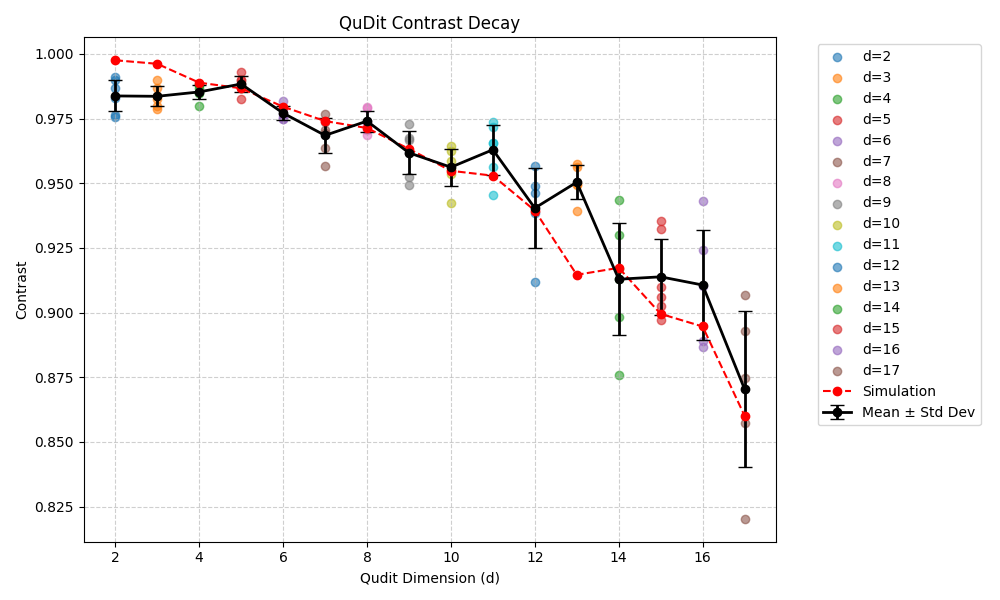

In [316]:
for d in diff_results:
    diff_results[d] = [val for val in diff_results[d] if not np.isnan(val)]

# Prepare data
d_values = sorted(diff_results.keys())
means = [np.mean(diff_results[d]) for d in d_values]
stds = [np.std(diff_results[d]) for d in d_values]

# Plot
plt.figure(figsize=(10, 6))

# Scatter plot for each individual point
for d in d_values:
    y_vals = diff_results[d]
    x_vals = [d] * len(y_vals)
    plt.scatter(x_vals, y_vals, label=f'd={d}', alpha=0.6)

# Plot mean ± std
contrast =  [0.9975416860015797, 0.9961728826901076, 0.9888852495872053, 0.9867048737478668, 0.9795963655166029, 0.9740436126031762, 0.9713451776114647, 0.963283779876942, 0.954813337751758, 0.9529299091744097, 0.9394567536979684, 0.9146043847875864, 0.9173107289055491, 0.8994924472630421, 0.8946232350494101, 0.8601217488489123]
plt.errorbar(d_values, means, yerr=stds, fmt='o-', color='black', label='Mean ± Std Dev', linewidth=2, capsize=5)
plt.plot(d_values, contrast,'ro--',label = 'Simulation')
print(d_values, means)
# Labels and formatting
plt.xlabel('Qudit Dimension (d)')
plt.ylabel('Contrast')
plt.title('QuDit Contrast Decay')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Read and Process data with error handling

In [1]:
%matplotlib widget

In [391]:
import re
from datetime import datetime
import os
import numpy as np
import json
import matplotlib.pyplot as plt

directory_path = 'Z:/Lab Data/Qudit_Ramsey_raw_data/Raw_data_PD/'

def parse_qudit_filename(filename):
    pattern = r'Ramsey_qudit_WaitTime\d+us_d=(\d+)_Cal_True_U1only_False_\d+_(\d{8})_(\d{4})\.txt'
    match = re.search(pattern, filename)
    if match:
        d_value = int(match.group(1))
        date_str = match.group(2) + match.group(3)
        date_time = datetime.strptime(date_str, '%Y%m%d%H%M')
        return d_value, date_time
    return None, None

def extract_raw_data_filenames(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    raw_data_filenames_line = lines[-1].strip()
    raw_data_filenames = [name.strip().strip("'\"") for name in raw_data_filenames_line.strip('[]').split(',')]
    return raw_data_filenames

# def search_files_by_d(directory, start_datetime=None):
#     d_value_dict = {}
#     for filename in os.listdir(directory):
#         if filename.startswith('Ramsey_qudit') and 'U1only_False' in filename:
#             d_value, date_time = parse_qudit_filename(filename)
#             # print(date_time)
#             if d_value is not None and (start_datetime is None or date_time >= start_datetime):
#                 file_path = os.path.join(directory, filename)
#                 raw_data_filenames = extract_raw_data_filenames(file_path)

#                 # 🔍 Filter: only accept text files with exactly 2 raw data file paths
#                 if len(raw_data_filenames) != 2:
#                     continue

#                 Z_drive_raw_data = 'Z:\\Lab Data\\Qudit_Ramsey_raw_data\\'
#                 raw_data_filepaths = [
#                     raw_filename if os.path.isabs(raw_filename) else os.path.join(Z_drive_raw_data, raw_filename)
#                     for raw_filename in raw_data_filenames
#                 ]

#                 if d_value not in d_value_dict:
#                     d_value_dict[d_value] = []

#                 # Append list of raw file paths (grouped by .txt file)
#                 d_value_dict[d_value].append(raw_data_filepaths)
#     return d_value_dict

def search_files_by_d(directory, start_datetime=None, stop_datetime=None):
    d_value_dict = {}
    for filename in os.listdir(directory):
        if not filename.startswith('Ramsey_qudit') or 'U1only_False' not in filename:
            continue
        d_value, date_time = parse_qudit_filename(filename)
        if d_value is None:
            continue
        # Filter by date window if provided
        if start_datetime and date_time < start_datetime:
            continue
        if stop_datetime  and date_time > stop_datetime:
            continue
        summary_path = os.path.join(directory, filename)
        raw_list = extract_raw_data_filenames(summary_path)
        if len(raw_list) != 2:
            continue
        base = 'Z:/Lab Data/Qudit_Ramsey_raw_data/'
        raw_paths = [f if os.path.isabs(f) else os.path.join(base, f) for f in raw_list]
        d_value_dict.setdefault(d_value, []).append(raw_paths)
    return d_value_dict

def search_files_by_d(directory, start_datetime=None, stop_datetime=None):
    d_value_dict = {}
    d_value_time_dict = {}
    for filename in os.listdir(directory):
        if not filename.startswith('Ramsey_qudit') or 'U1only_False' not in filename:
            continue
        d_value, date_time = parse_qudit_filename(filename)
        if d_value is None:
            continue
        if start_datetime and date_time < start_datetime:
            continue
        if stop_datetime and date_time > stop_datetime:
            continue
        summary_path = os.path.join(directory, filename)
        raw_list = extract_raw_data_filenames(summary_path)
        if len(raw_list) != 2:
            continue
        base = 'Z:/Lab Data/Qudit_Ramsey_raw_data/'
        raw_paths = [f if os.path.isabs(f) else os.path.join(base, f) for f in raw_list]
        d_value_dict.setdefault(d_value, []).append(raw_paths)
        d_value_time_dict.setdefault(d_value, []).append(date_time)
    return d_value_dict, d_value_time_dict

    
# Calculate the shelving threshold
def get_shelving_threshold(counts):
    data_sorted = np.sort(counts, axis=None)[300:-300]
    if len(data_sorted) > 1000:
        data_sorted = data_sorted[0:-1:round(data_sorted.size / (len(counts) * 0.00450167))]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    # if threshold < 2:
    #     threshold = 10
    # plt.figure()
    # plt.plot(data_sorted)
    # plt.axhline(threshold,color='r')
    # plt.show()
    return threshold, data_sorted

def getShelvingThreshold(counts):
    data_sorted = np.sort(counts, axis=None)
    print("Total sorted data points:", len(data_sorted))
    # Remove extreme ends (if possible)
    if len(data_sorted) > 4000:
        data_sorted = data_sorted[2000:-2000]
    if len(data_sorted) > 2000:
        step = round(data_sorted.size / (len(counts) * 0.0250167))
        if step < 1:
            step = 1
        data_sorted = data_sorted[0:-1:step]
    data_sorted_diff = data_sorted[1:-1] - data_sorted[0:-2]
    data_diff_max = max(data_sorted_diff)
    data_diff_maxind = np.argmax(data_sorted_diff)
    threshold = data_diff_max / 2 + data_sorted[data_diff_maxind]
    
    # New logic: if the calculated threshold is less than 2, recalculate using histogram data.
    # if threshold < 2:
        # Calculate histogram in the x-range 4 to 30
    hist_counts, bin_edges = np.histogram(counts, bins=range(4, 31))
    # Find the bin (lowest bar) with the minimum count in that range
    min_bin_index = np.argmin(hist_counts)
    # Use the lower edge of that bin as the threshold
    threshold = bin_edges[min_bin_index] + 0.5
    print(f"Threshold recalculated using histogram: {threshold}")
    
    return threshold, data_sorted

def find_errors(num_SD, full_data_array, exp_num):
            upper_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                           (1 + (num_SD**2 / exp_num))) + (np.sqrt(
                               ((full_data_array *
                                 (1 - full_data_array) * num_SD**2) / exp_num) +
                               (num_SD**4 /
                                (4 * exp_num**2)))) / (1 + (num_SD**2 / exp_num))
            
            lower_error = ((full_data_array + (num_SD**2 / (2 * exp_num))) /
                           (1 + (num_SD**2 / exp_num))) - (np.sqrt(
                               ((full_data_array *
                                 (1 - full_data_array) * num_SD**2) / exp_num) +
                               (num_SD**4 /
                                (4 * exp_num**2)))) / (1 + (num_SD**2 / exp_num))
            return lower_error, upper_error

def process_raw_data_files(grouped_raw_data_filepaths, num_SD=1):
    ket_data_group = []
    error_bars_group = []  # New list to hold error bars

    for file_group in grouped_raw_data_filepaths:
        group_kets = []
        group_errors = []

        arrays = []
        for file_path in file_group:
            with open(file_path, 'r') as file:
                for line in file:
                    data = json.loads(line)
                    arrays.append(data[0]["0"])
        hist_data = np.array(arrays)
        flat_hist_data = hist_data.flatten()
        threshold, _ = get_shelving_threshold(flat_hist_data)
        print("\nThreshold:", threshold)

        arrays_3d = []
        for file_path in file_group:
            arrays = []
            with open(file_path, 'r') as file:
                for line in file:
                    data = json.loads(line)
                    arrays.append(data[0]["0"][:])
            arrays_3d.append(arrays)

        bool_array = np.array(arrays_3d) > 8
        result_matrix = np.full(bool_array.shape, False, dtype=bool)

        not_all_darks = []
        first_h = []

        for matrix_index in range(bool_array.shape[0]):
            not_all_dark_counts = 0
            first_h_num = 0
            for row_index in range(bool_array.shape[1]):
                true_indices = np.where(bool_array[matrix_index, row_index, :])
                if true_indices[0].size > 0:
                    first_true_index = true_indices[0]
                    not_all_dark_counts += 1
                    if first_true_index[0] != 0:
                        first_h_num += 1
                        result_matrix[matrix_index, row_index, first_true_index[0]] = True
            first_h.append(first_h_num)
            not_all_darks.append(not_all_dark_counts)

        print(not_all_darks)
        filtered_data_array = []
        for i in range(bool_array.shape[0]):
            data = result_matrix[i]
            rows_with_any_true = data.any(axis=1)
            filtered_data = data[rows_with_any_true]
            
            filtered_data_array.append(filtered_data)
            exp_num = filtered_data.shape[0]  # number of experiments
            print(i, '|| all darks =', data.shape[0] - not_all_darks[i],
                  '|| failing first herald =', not_all_darks[i] - filtered_data.shape[0],
                  '|| deshelving error =', np.round((not_all_darks[i] - filtered_data.shape[0]), 3),
                  filtered_data.shape[0], file_group[i])
        
            if exp_num > 0:
                ket_mean = np.sum(filtered_data, axis=0)[1:] / (filtered_data.shape[0] + (data.shape[0] - not_all_darks[i]))
                lower_err, upper_err = find_errors(num_SD, ket_mean, exp_num)
                error = [ket_mean - lower_err, upper_err - ket_mean]
            else:
                ket_mean = np.zeros(filtered_data.shape[1] - 1)
                error = [np.zeros_like(ket_mean), np.zeros_like(ket_mean)]

            group_kets.append(ket_mean)
            group_errors.append(error)

        ket_data_group.append(group_kets)
        error_bars_group.append(group_errors)

    return ket_data_group, error_bars_group


def process_all_d_values(d_value_dict, num_SD=1):
    processed_data_dict = {}
    processed_error_dict = {}

    for d_value, grouped_raw_file_lists in d_value_dict.items():
        print(f'_______________d = {d_value} _________________')
        ket_data_group, error_bars_group = process_raw_data_files(grouped_raw_file_lists, num_SD=num_SD)
        processed_data_dict[d_value] = ket_data_group
        processed_error_dict[d_value] = error_bars_group

    return processed_data_dict, processed_error_dict


start_datetime = datetime.strptime('20250415_1636', '%Y%m%d_%H%M')
# start_datetime = datetime.strptime('20250411_1336', '%Y%m%d_%H%M')
# start_datetime = datetime.strptime('20250416_1305', '%Y%m%d_%H%M')
# start_datetime = datetime.strptime('20250411_1336', '%Y%m%d_%H%M')
# stop_datetime  = datetime.strptime('20250415_1636', '%Y%m%d_%H%M')
d_value_dict, d_values_date_time = search_files_by_d(directory_path, start_datetime=start_datetime)#, stop_datetime=stop_datetime)

processed_data, processed_errors = process_all_d_values(d_value_dict, num_SD=1)

# print(processed_data)

_______________d = 17 _________________

Threshold: 11.0
[1000, 988]
0 || all darks = 0 || failing first herald = 14 || deshelving error = 14 986 Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_04\\2025_04_15\\qudit_ramsey_scan_unbused_109
1 || all darks = 12 || failing first herald = 21 || deshelving error = 21 967 Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_04\\2025_04_15\\qudit_ramsey_scan_unbused_110

Threshold: 9.5
[1000, 982]
0 || all darks = 0 || failing first herald = 10 || deshelving error = 10 990 Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_04\\2025_04_15\\qudit_ramsey_scan_unbused_150
1 || all darks = 18 || failing first herald = 7 || deshelving error = 7 975 Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_copied\\2025\\2025_04\\2025_04_15\\qudit_ramsey_scan_unbused_151

Threshold: 8.5
[998, 990]
0 || all darks = 2 || failing first herald = 10 || deshelving error = 10 988 Z:\\Lab Data\\Qudit_Ramsey_raw_data\\Raw_data_c

In [393]:
print(d_values_date_time)
with open('d_values_date_time.txt', 'w') as f:
    for d_value, date_times in d_values_date_time.items():
        f.write(f"{d_value}:\n")
        for dt in date_times:
            f.write(f"  {dt}\n")


{17: [datetime.datetime(2025, 4, 15, 17, 21), datetime.datetime(2025, 4, 15, 23, 23), datetime.datetime(2025, 4, 16, 2, 10), datetime.datetime(2025, 4, 16, 4, 45), datetime.datetime(2025, 4, 16, 7, 27), datetime.datetime(2025, 4, 15, 18, 21), datetime.datetime(2025, 4, 16, 22, 20), datetime.datetime(2025, 4, 17, 9, 11), datetime.datetime(2025, 4, 17, 15, 59), datetime.datetime(2025, 4, 17, 19, 18), datetime.datetime(2025, 4, 18, 15, 16), datetime.datetime(2025, 4, 18, 19, 19), datetime.datetime(2025, 4, 18, 19, 43), datetime.datetime(2025, 4, 18, 22, 50), datetime.datetime(2025, 4, 18, 23, 16), datetime.datetime(2025, 5, 20, 23, 26), datetime.datetime(2025, 5, 20, 23, 51)], 16: [datetime.datetime(2025, 4, 15, 17, 21), datetime.datetime(2025, 4, 15, 23, 23), datetime.datetime(2025, 4, 16, 2, 10), datetime.datetime(2025, 4, 16, 4, 45), datetime.datetime(2025, 4, 16, 7, 27), datetime.datetime(2025, 4, 15, 18, 21), datetime.datetime(2025, 4, 16, 18, 18), datetime.datetime(2025, 4, 16, 22, 

In [395]:
diff_results = {}      
diff_error_results = {} 

for d, entries in processed_data.items():
    diffs = []
    diff_errors = [] 
    for i, pair in enumerate(entries):
        high_val = pair[0][0]  
        low_val  = pair[1][0] 
        diff = high_val - low_val

        high_err = processed_errors[d][i][0]  
        low_err  = processed_errors[d][i][1]  
        # print('he--------',high_err,'le---------', low_err)
        high_err_lower = high_err[0][0]  
        high_err_upper = high_err[1][0]  
        low_err_lower  = low_err[0][0]   
        low_err_upper  = low_err[1][0]   
        
        diff_upper = np.sqrt(high_err_upper**2 + low_err_lower**2)
        diff_lower = np.sqrt(high_err_lower**2 + low_err_upper**2)
        
        diffs.append(diff)
        diff_errors.append((diff_lower, diff_upper))
    diff_results[d] = diffs
    diff_error_results[d] = diff_errors

for d in sorted(diff_results.keys()):
    print(f"d = {d}")
    for idx, diff in enumerate(diff_results[d]):
        diff_lower, diff_upper = diff_error_results[d][idx]
        print(f"Pair {idx}: Difference = {diff} with errors (-{diff_lower}, +{diff_upper})")


d = 2
Pair 0: Difference = 0.982829285612984 with errors (-0.004926628451602082, +0.003513926505872184)
Pair 1: Difference = 0.9869122027356082 with errors (-0.004394507622464177, +0.0029864186797780813)
Pair 2: Difference = 0.9798345997741768 with errors (-0.0052439535398903165, +0.00384951752809673)
Pair 3: Difference = 0.971630856570927 with errors (-0.006075571627975422, +0.004682274149050407)
Pair 4: Difference = 0.9889183740180741 with errors (-0.004121238800927173, +0.0027070823232638493)
Pair 5: Difference = 0.9788260731990296 with errors (-0.005352131397469533, +0.003962965392851598)
Pair 6: Difference = 0.9755409003911126 with errors (-0.005717505553903697, +0.004313370447462487)
Pair 7: Difference = 0.9848226289407934 with errors (-0.004662588627571419, +0.0032854550255100295)
Pair 8: Difference = 0.9178800755878497 with errors (-0.009729931449179696, +0.00839925994539063)
Pair 9: Difference = 0.9807794648010709 with errors (-0.005157175994914849, +0.003748828086474773)
Pair

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24] [0.9816088924680841, 0.9810177396824891, 0.9840248176724236, 0.9873842279055991, 0.9746642267424086, 0.9704275792806987, 0.9737747790836616, 0.9660132230133527, 0.9588779402907619, 0.964003939293143, 0.9444803170731868, 0.9471654717705862, 0.9254951223363005, 0.9160664468967179, 0.9170431282186959, 0.8820253270797471, 0.7360330009378899, 0.6884042053391878, 0.6261238254627713, 0.47174465948903943, 0.423691002873044, 0.30320230936182024, 0.16391485197879807] [0.0039518037405281755, 0.005793170418442932, 0.0036624429226276532, 0.00391946456958901, 0.004154504663680588, 0.0050675890995728196, 0.0035905981353412356, 0.0037200038725233656, 0.004268336420453015, 0.006482850697692332, 0.005553816199373844, 0.006084261957257811, 0.009786889271514193, 0.01186860828182297, 0.010777739674098206, 0.014685106543518463, 0.05817406296598282, 0.07209466766852173, 0.03244715455261379, 0.024157382573218956, 0.0282199821

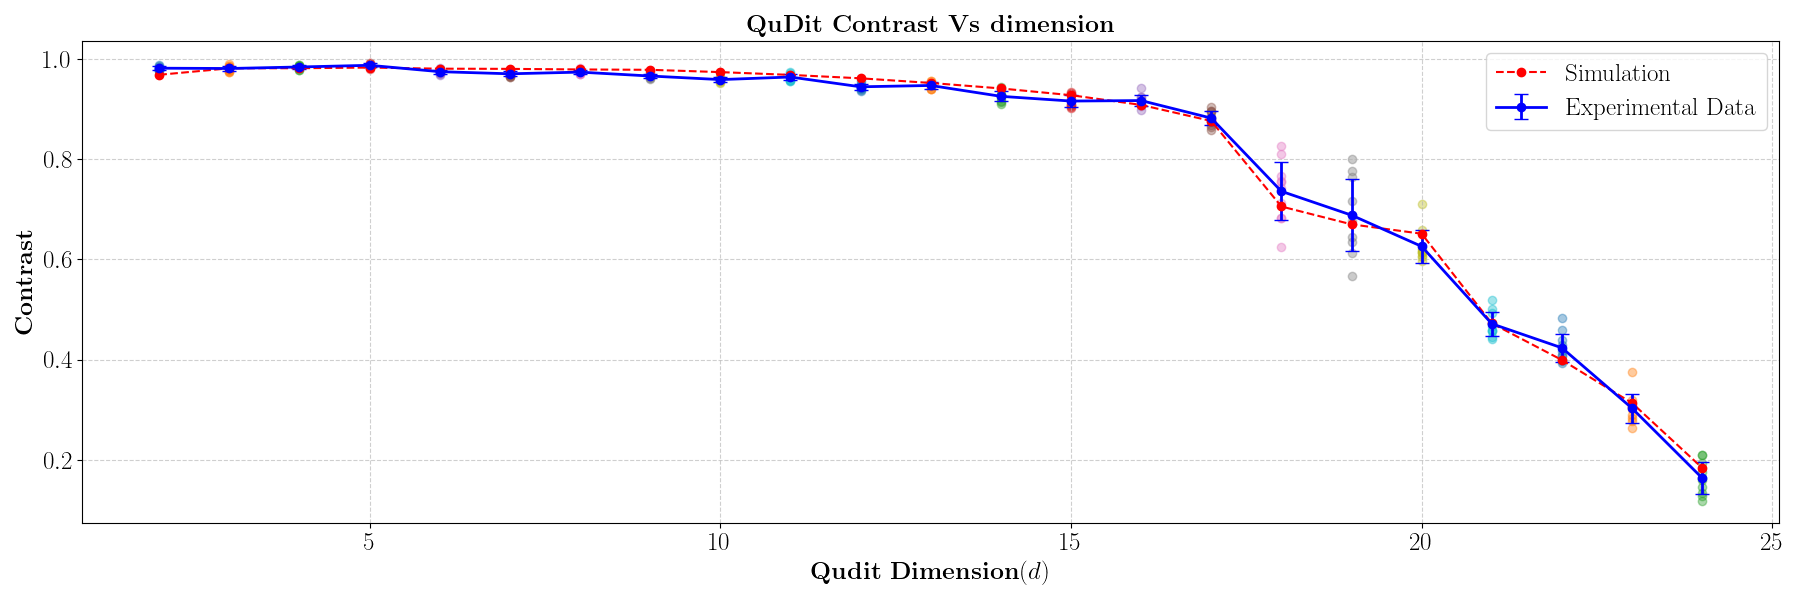

d values =  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
unweighted_means: [0.9816088924680841, 0.9810177396824891, 0.9840248176724236, 0.9873842279055991, 0.9746642267424086, 0.9704275792806987, 0.9737747790836616, 0.9660132230133527, 0.9588779402907619, 0.964003939293143, 0.9444803170731868, 0.9471654717705862, 0.9254951223363005, 0.9160664468967179, 0.9170431282186959, 0.8820253270797471, 0.7360330009378899, 0.6884042053391878, 0.6261238254627713, 0.47174465948903943, 0.423691002873044, 0.30320230936182024, 0.16391485197879807]
unweighted_stds: [0.0039518037405281755, 0.005793170418442932, 0.0036624429226276532, 0.00391946456958901, 0.004154504663680588, 0.0050675890995728196, 0.0035905981353412356, 0.0037200038725233656, 0.004268336420453015, 0.006482850697692332, 0.005553816199373844, 0.006084261957257811, 0.009786889271514193, 0.01186860828182297, 0.010777739674098206, 0.014685106543518463, 0.05817406296598282, 0.07209466766852173, 0.032447

In [399]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

for d in diff_results:
    diff_results[d] = [val for val in diff_results[d] if not np.isnan(val)]
    valid_indices = [i for i, val in enumerate(diff_results[d])]
    diff_error_results[d] = [diff_error_results[d][i] for i in valid_indices]

for d in diff_results:
    vals = np.array(diff_results[d])
    errs = np.array(diff_error_results[d])
    
    # Remove NaNs
    valid_mask = ~np.isnan(vals)
    vals = vals[valid_mask]
    errs = errs[valid_mask]

    # Get indices of top 10 values
    if len(vals) > 10:
        top_indices = np.argsort(vals)[-10:]  # Indices of 10 highest values
        vals = vals[top_indices]
        errs = errs[top_indices]
    
    diff_results[d] = list(vals)
    diff_error_results[d] = [tuple(e) for e in errs]


d_values = sorted(diff_results.keys())

weighted_means = []
weighted_errors = []
for d in d_values:
    diffs = np.array(diff_results[d])
    errors = np.array(diff_error_results[d])
    
    effective_errors = (errors[:, 0] + errors[:, 1]) / 2.0
    
    weights = 1.0 / (effective_errors**2)
    
    weighted_mean = np.sum(diffs * weights) / np.sum(weights)
    
    weighted_error = np.sqrt(1.0 / np.sum(weights))
    
    weighted_means.append(weighted_mean)
    weighted_errors.append(weighted_error)

unweighted_means = [np.mean(diff_results[d]) for d in d_values]
unweighted_stds  = [np.std(diff_results[d]) for d in d_values]

contrast = [0.9975416860015797, 0.9961728826901076, 0.9888852495872053, 0.9867048737478668,
            0.9795963655166029, 0.9740436126031762, 0.9713451776114647, 0.963283779876942,
            0.954813337751758, 0.9529299091744097, 0.9394567536979684, 0.9146043847875864,
            0.9173107289055491, 0.8994924472630421, 0.8946232350494101, 0.8601217488489123]
contrast = [0.9996765006584116, 0.997480371601701, 0.9923988048074331, 0.9864408366807862, 0.9795479694138638, 0.9667961931551211, 0.9712526450294161, 0.9590262929059999, 0.9557267290245565, 0.9456916870818702, 0.9324663453664707, 0.9257507898074301, 0.9173487326977111, 0.8952576560855208, 0.8854247303648352, 0.8642769373218255]
# contrast = [0.9963459387929209, 0.992931217875534, 0.9874761979988032, 0.9851014712474616, 0.9700577337817338, 0.9658640254389959, 0.9575808104271027, 0.9473636140260141, 0.9356764015011293, 0.9273641037410498, 0.917604402925294, 0.8974368957705773, 0.8881616418744787, 0.8773102399297255, 0.8603123997276236, 0.8464091737752268]

contrast = [0.9985099673220128, 0.9930058005521334, 0.9905326573541903, 0.9841170209223088, 0.9605354584908964, 0.9589056934821535, 0.946375127159727, 0.9417481184525748, 0.9341987877081934, 0.9240629460462837, 0.8951415858440811, 0.8796801289786671, 0.8543159486359679, 0.8232161210410381, 0.8070366016668321, 0.7822740608212084, 0.6520108078983877]
contrast = [0.9968340606981674, 0.9947658364634979, 0.9902899766565648, 0.9834733965419036, 0.9667330002496272, 0.9584598178956303, 0.9558750339522488, 0.9491428118457265, 0.9379526555011017, 0.9291493269827311, 0.9064041553131791, 0.8879143934727124, 0.8789947102119106, 0.8536062743497717, 0.8284455383407332, 0.8142383571743802, 0.671343827036302]
contrast = [0.9999631533556211, 0.9997773625392986, 0.9991694527789773, 0.9979842664938943, 0.9925027689175231, 0.9896165232119818, 0.9865572406977002, 0.9800113978979824, 0.9781423346900282, 0.972204265732806, 0.9621608384128492, 0.9461396129836964, 0.930160861977644, 0.9065008772672678, 0.8862056482739564, 0.8483814358557196, 0.6559615208917384]
contrast = [0.9935384386274618, 0.9992775675208037, 0.9953647137412551, 0.9968641230296752, 0.983928432517173, 0.9801285001025907, 0.9681901734693946, 0.9591977844147859, 0.9359469410379622, 0.954857290476437, 0.8630870783684483, 0.9096516378815541, 0.8056411032090105, 0.8113181848153775, 0.6571581281934792, 0.7050348240632164, 0.6433565138396564]

contrast = [0.9993465377789457, 0.9972170450415047, 0.9961356845077093, 0.9933023680144346, 0.981212651460685, 0.9776621731379467, 0.9745974585351664, 0.9682663615020226, 0.9622876521628043, 0.9516495696683378, 0.9420924348052475, 0.918017045489397, 0.9093626407163357, 0.8748605648115602, 0.853862594200336, 0.8114691402037104, 0.6326654199350387]
contrast =[0.9684418914530947, 0.981415333706525, 0.9815490953185407, 0.9828733268041747, 0.9806293579538039, 0.9802583692836084, 0.9790923373522288, 0.9783807718255144, 0.973808778535228, 0.9682330506920294, 0.9614310000487739, 0.9521735329288974, 0.9412306781498648, 0.9277826482150446, 0.9083603752763076, 0.8763195996707197, 0.705706046626361, 0.6701036423835008, 0.6513762478112451, 0.4726565690351758, 0.39946490809552815, 0.3136180602379757, 0.18428113289149362]

# contrast =[0.9678007062570054,
#  0.9788877018780143,
#  0.9798462618475845,
#  0.982524780239838,
#  0.9804847952819367,
#  0.9815148668579969,
#  0.9784597173670336,
#  0.9742823286046087,
#  0.9744193776205621,
#  0.967520782216834,
#  0.9588794399840663,
#  0.9434764003835736,
#  0.93675057819979,
#  0.9173737350056342,
#  0.8982108915233928,
#  0.8719630926468716,
#  0.6628010103521894,
#  0.6782574663189247,
#  0.6381970274347358,
#  0.4644109312239861,
#  0.4012166897739838,
#  0.3100779559265937]

contrast_pi_t = [0.9684418914530947, 0.981415333706525, 0.9815490953185407, 0.9828733268041747, 0.9806293579538039, 0.9802583692836084, 0.9790923373522288, 0.9783807718255144, 0.973808778535228, 0.9682330506920294, 0.9614310000487739, 0.9521735329288974, 0.9412306781498648, 0.9277826482150446, 0.9083603752763076, 0.8763195996707197, 0.705706046626361, 0.6701036423835008, 0.6513762478112451, 0.4726565690351758, 0.39946490809552815, 0.3136180602379757, 0.18428113289149362]

contrast = np.array(contrast) 
plt.figure(figsize=(18, 6))

for d in d_values:
    y_vals = diff_results[d]
    x_vals = [d] * len(y_vals)
    plt.scatter(x_vals, y_vals,alpha = 0.4)# label=f'd={d}', alpha=0.6)

print(d_values, unweighted_means, unweighted_stds)

plt.errorbar(d_values, unweighted_means, yerr=unweighted_stds, fmt='o-', color='blue',
             label='Experimental Data', linewidth=2, capsize=5)

# plt.errorbar(d_values, weighted_means, yerr=weighted_errors, fmt='s-', color='black',
#              label='Weighted Mean ± Error', linewidth=2, capsize=5)

plt.plot(range(2,25), contrast, 'ro--', label='Simulation')
# plt.plot(range(2,24), contrast_pi_t, 'ko--', label='Simulation')

plt.xlabel(r'$\textbf{Qudit Dimension} \boldmath{(d)}$', fontsize = 18)
plt.ylabel(r'$\textbf{Contrast}$', fontsize = 18)
# plt.ylim(0.75,1.01)
plt.tick_params(axis='both', labelsize=18)  
plt.title(r'$\textbf{QuDit Contrast Vs dimension}$', fontsize = 18)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize = 18)#bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Qudit_contrast_vs_dimension.svg')
plt.show()

# # Debug print-out
print("d values = ", d_values)
print("unweighted_means:", unweighted_means)
print("unweighted_stds:", unweighted_stds)


In [294]:
%matplotlib widget

In [296]:
(1-10e-4)**4

0.996005996001

In [317]:
1/23

0.043478260869565216